Deep Neural Network

In [96]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
# from utils.helper import fn_plot_tf_hist

In [97]:
def fn_plot_tf_hist(hist_df):

    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: accuracy
            column 1: loss
            column 2: val_accuracy
            column 3: val_loss
            While plotting columns are accessed by index
            so that even if the column names are different it will not throw exceptions.
    '''

    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm

    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y4] == hist_df[y4].min()]

    ax = axes[0]

    hist_df.plot(y = [y2,y4], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = '{:s}: \n  train: {:6.4f}\n   test: {:6.4f}'
    txtstr = txtFmt.format(y2.capitalize(),
                           hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0] + offset), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3)

    ax.set_xlabel('Epochs')
    ax.set_ylabel(y2.capitalize())
    ax.set_title('Errors')
    ax.grid(True)
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y1, y3], ax = ax, colormap=CMAP)

    # little beautification
    txtFmt = '{:s}: \n  train: {:6.4f}\n  test:  {:6.4f}'
    txtstr = txtFmt.format(y1.capitalize(),
                           hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0]-offset), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow


    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3)

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.grid(True)
    ax.legend(loc = 'lower left')

    plt.tight_layout()

In [98]:
### ----------------------
### global variables
### ----------------------

import random

RANDOM_STATE = 24
tf.random.set_seed(RANDOM_STATE)


TEST_SIZE = 3811
ALPHA = 0.001 # LEARNING RATE
EPOCHS = 100  # NUMBER OF ITERATIONS
BATCH_SIZE = 256

# input and output directories
inpDir = '../../input'
outDir = '../output'

params = {
    'legend.fontsize': 'medium',
    'figure.figsize': (10, 6),
    'axes.labelsize': 'medium',
    'axes.titlesize':'large',
    'xtick.labelsize':'medium',
    'ytick.labelsize':'medium'
}

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid')

# Load Data

In [99]:
data_df = pd.read_csv("fifa_2019.csv")
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


# EDA
1. Remove Null from Position
2. Read unique values from the columns

In [100]:
data_df = data_df[data_df["Position"].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [101]:
data_df.shape

(18147, 89)

In [102]:
for col in data_df.columns:
    unq = data_df[col].unique()
    print(f'{col}, # : {len(unq)}, Values: {unq}')

Unnamed: 0, # : 18147, Values: [    0     1     2 ... 18204 18205 18206]
ID, # : 18147, Values: [158023  20801 190871 ... 241638 246268 246269]
Name, # : 17140, Values: ['L. Messi' 'Cristiano Ronaldo' 'Neymar Jr' ... 'B. Worman'
 'D. Walker-Rice' 'G. Nugent']
Age, # : 29, Values: [31 33 26 27 32 25 29 28 24 30 19 40 22 23 34 35 36 37 21 18 20 39 41 17
 38 45 42 16 44]
Photo, # : 18147, Values: ['https://cdn.sofifa.org/players/4/19/158023.png'
 'https://cdn.sofifa.org/players/4/19/20801.png'
 'https://cdn.sofifa.org/players/4/19/190871.png' ...
 'https://cdn.sofifa.org/players/4/19/241638.png'
 'https://cdn.sofifa.org/players/4/19/246268.png'
 'https://cdn.sofifa.org/players/4/19/246269.png']
Nationality, # : 164, Values: ['Argentina' 'Portugal' 'Brazil' 'Spain' 'Belgium' 'Croatia' 'Uruguay'
 'Slovenia' 'Poland' 'Germany' 'France' 'England' 'Italy' 'Egypt'
 'Colombia' 'Denmark' 'Gabon' 'Wales' 'Senegal' 'Costa Rica' 'Slovakia'
 'Netherlands' 'Bosnia Herzegovina' 'Morocco' 'Serbia' 'Alge

In [103]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18147 entries, 0 to 18206
Data columns (total 89 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                18147 non-null  int64  
 1   ID                        18147 non-null  int64  
 2   Name                      18147 non-null  object 
 3   Age                       18147 non-null  int64  
 4   Photo                     18147 non-null  object 
 5   Nationality               18147 non-null  object 
 6   Flag                      18147 non-null  object 
 7   Overall                   18147 non-null  int64  
 8   Potential                 18147 non-null  int64  
 9   Club                      17918 non-null  object 
 10  Club Logo                 18147 non-null  object 
 11  Value                     18147 non-null  object 
 12  Wage                      18147 non-null  object 
 13  Special                   18147 non-null  int64  
 14  Preferred F

In [104]:
rel_cols = ['Position', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
            'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning',
            'GKReflexes']

data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,RF,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,ST,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,LW,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,GK,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,RCM,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [105]:
data_df.isna().sum().sum()

0

In [106]:
data_df['Position'].unique()

array(['RF', 'ST', 'LW', 'GK', 'RCM', 'LF', 'RS', 'RCB', 'LCM', 'CB',
       'LDM', 'CAM', 'CDM', 'LS', 'LCB', 'RM', 'LAM', 'LM', 'LB', 'RDM',
       'RW', 'CM', 'RB', 'RAM', 'CF', 'RWB', 'LWB'], dtype=object)

In [107]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS', 'LS', 'CF']
midfielder = ['CM', 'RCM', 'LCM', 'CDM', 'RDM', 'LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [108]:
data_df.loc[data_df['Position'] == 'GK', 'Position'] = 0
data_df.loc[data_df['Position'].isin(defender), 'Position'] = 1
data_df.loc[data_df['Position'].isin(midfielder), 'Position'] = 2
data_df.loc[data_df['Position'].isin(forward), 'Position'] = 3
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast = 'integer')

<ipython-input-108-407474dd2fca>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['Position'] = pd.to_numeric(data_df['Position'], downcast = 'integer')


In [109]:
data_df['Position'].unique()

array([3, 0, 2, 1], dtype=int8)

In [110]:
class_labels = {0 : 'Goalkeeper', 1 : 'Defender', 2 : 'Midfielder', 3 : 'Forward'}

In [111]:
x = data_df.drop('Position', axis = 1)
y = data_df['Position'].to_numpy()

In [112]:
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    random_state = RANDOM_STATE,
                                                    stratify = y,
                                                    test_size = TEST_SIZE)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((14336, 33), (3811, 33), (14336,), (3811,))

In [113]:
type(x_train), type(x_test), type(y_train), type(y_test)

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 numpy.ndarray,
 numpy.ndarray)

In [114]:
sc = StandardScaler()

x_train = sc.fit_transform(x_train, y_train)
x_test = sc.transform(x_test)

In [115]:
x_train.shape, x_test.shape

((14336, 33), (3811, 33))

Converting to dataset

In [116]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
type(x_train), type(y_train)

(numpy.ndarray, numpy.ndarray)

Preprocessing and Batching

In [117]:
train_ds = train_ds.shuffle(buffer_size = x_train.shape[0]).batch(BATCH_SIZE)
test_ds = test_ds.shuffle(buffer_size = x_test.shape[0]).batch(BATCH_SIZE)

In [118]:
train_ds = train_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

In [143]:
next(iter(train_ds))

(<tf.Tensor: shape=(256, 33), dtype=float64, numpy=
 array([[ 0.84327811,  0.67601238,  1.44857044, ..., -0.55936467,
         -0.55145134, -0.42982942],
        [-1.00037375,  1.53865868,  0.29297255, ..., -0.3164643 ,
         -0.55145134, -0.3182802 ],
        [-0.9491612 ,  0.67601238, -0.59071995, ..., -0.55936467,
         -0.6692196 , -0.37405481],
        ...,
        [-0.89794865,  1.13609041,  0.42892525, ..., -0.37718939,
         -0.49256722, -0.20673099],
        [-1.51249927, -2.19947527, -2.90191573, ...,  3.20559096,
          3.33490115,  2.97242174],
        [ 1.09934087,  0.9060514 , -0.11488553, ..., -0.19501412,
         -0.61033547, -0.54137864]])>,
 <tf.Tensor: shape=(256,), dtype=int8, numpy=
 array([2, 1, 1, 2, 2, 1, 2, 2, 0, 1, 2, 2, 2, 0, 2, 2, 2, 0, 3, 2, 2, 0,
        1, 2, 1, 1, 3, 1, 0, 2, 2, 2, 1, 2, 1, 3, 1, 3, 1, 1, 1, 1, 2, 3,
        3, 2, 1, 2, 2, 3, 1, 1, 0, 2, 0, 2, 3, 0, 2, 3, 2, 3, 2, 1, 3, 1,
        3, 0, 1, 1, 0, 2, 1, 2, 1, 1, 3, 2, 2, 2, 2,

In [144]:
model = tf.keras.Sequential([
    tf.keras.Input(shape = (x_train.shape[1], ), name = "input"),            # input layer
    tf.keras.layers.Dense(18, activation = tf.nn.relu, name = "fc_1"),   # Layer 1
    tf.keras.layers.Dense(4, name = "output")
])

In [120]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ fc_1 (Dense)                         │ (None, 18)                  │             612 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 4)                   │              76 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 688 (2.69 KB)

 Trainable params: 688 (2.69 KB)

 Non-trainable params: 0 (0.00 B)

In [142]:
prediction = model(x_train[:1]).numpy()
prediction.sum()

-2.117274

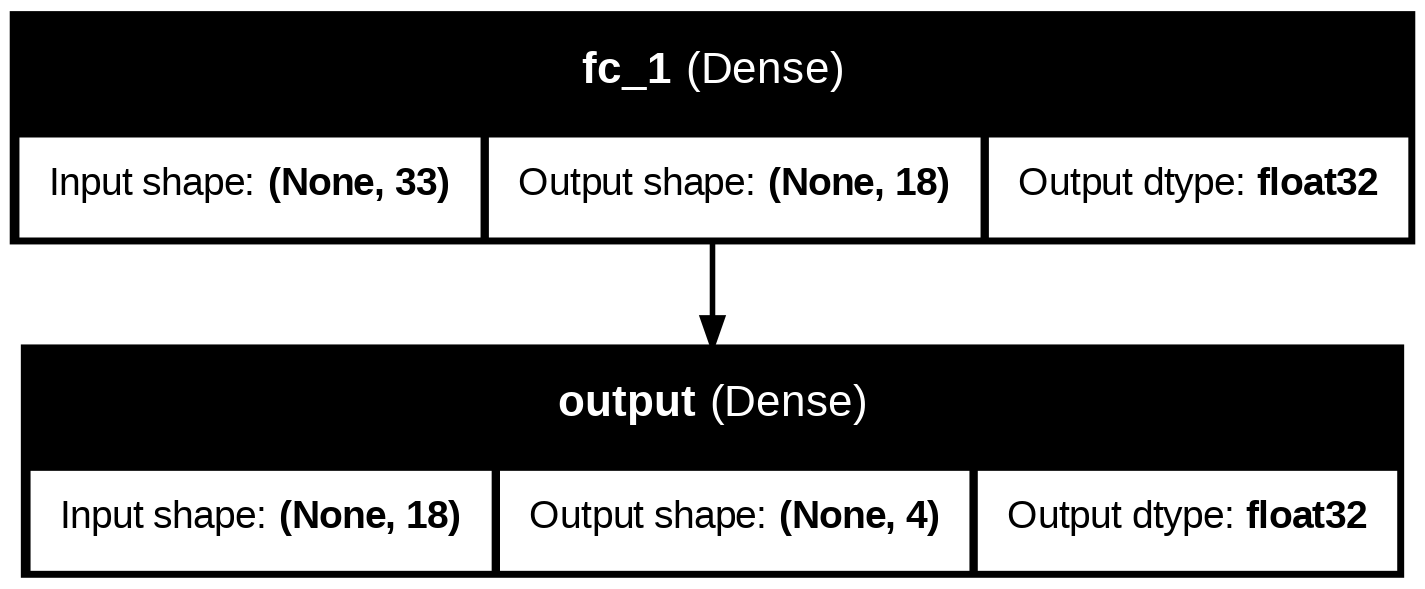

In [145]:

tf.keras.utils.plot_model(model, "my_first_model.png",
                         show_shapes = True,
                         show_dtype = True,
                         show_layer_names = True)


In [146]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

In [147]:
loss_fn(y_train[:1], prediction).numpy()

1.5601794

In [148]:
optimizer = tf.keras.optimizers.Adam(learning_rate = ALPHA)
model.compile(optimizer = optimizer,
              loss = loss_fn,
              metrics = ["accuracy"])

In [149]:
# history = model.fit(x_train, y_train,
#                     validation_data = [x_test, y_test],
#                     batch_size = BATCH_SIZE,
#                     verbose = 0,
#                     epochs = EPOCHS)

history = model.fit(train_ds,
                    validation_data = test_ds,
                    verbose = 2,
                    epochs = EPOCHS)

Epoch 1/100
56/56 - 1s - 16ms/step - accuracy: 0.6090 - loss: 0.9436 - val_accuracy: 0.7444 - val_loss: 0.6792
Epoch 2/100
56/56 - 0s - 1ms/step - accuracy: 0.7757 - loss: 0.5823 - val_accuracy: 0.7940 - val_loss: 0.5150
Epoch 3/100
56/56 - 0s - 3ms/step - accuracy: 0.8130 - loss: 0.4713 - val_accuracy: 0.8155 - val_loss: 0.4450
Epoch 4/100
56/56 - 0s - 2ms/step - accuracy: 0.8334 - loss: 0.4156 - val_accuracy: 0.8271 - val_loss: 0.4042
Epoch 5/100
56/56 - 0s - 2ms/step - accuracy: 0.8476 - loss: 0.3812 - val_accuracy: 0.8389 - val_loss: 0.3770
Epoch 6/100
56/56 - 0s - 2ms/step - accuracy: 0.8558 - loss: 0.3586 - val_accuracy: 0.8462 - val_loss: 0.3586
Epoch 7/100
56/56 - 0s - 2ms/step - accuracy: 0.8608 - loss: 0.3435 - val_accuracy: 0.8491 - val_loss: 0.3462
Epoch 8/100
56/56 - 0s - 2ms/step - accuracy: 0.8644 - loss: 0.3330 - val_accuracy: 0.8523 - val_loss: 0.3374
Epoch 9/100
56/56 - 0s - 2ms/step - accuracy: 0.8678 - loss: 0.3254 - val_accuracy: 0.8565 - val_loss: 0.3310
Epoch 10/

In [128]:
# y_pred = model.predict(train_ds)
# accuracy_score(y_true = y_train,
#                y_pred = y_pred.argmax(axis = 1))



56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


0.2904575892857143

In [150]:
hist_df = pd.DataFrame(history.history)
display(hist_df.head())

,accuracy,loss,val_accuracy,val_loss
0,0.608956,0.943615,0.744424,0.679170
1,0.775670,0.582286,0.794017,0.514961
2,0.812988,0.471283,0.815534,0.445026
3,0.833426,0.415591,0.827080,0.404208
4,0.847587,0.381173,0.838887,0.376960


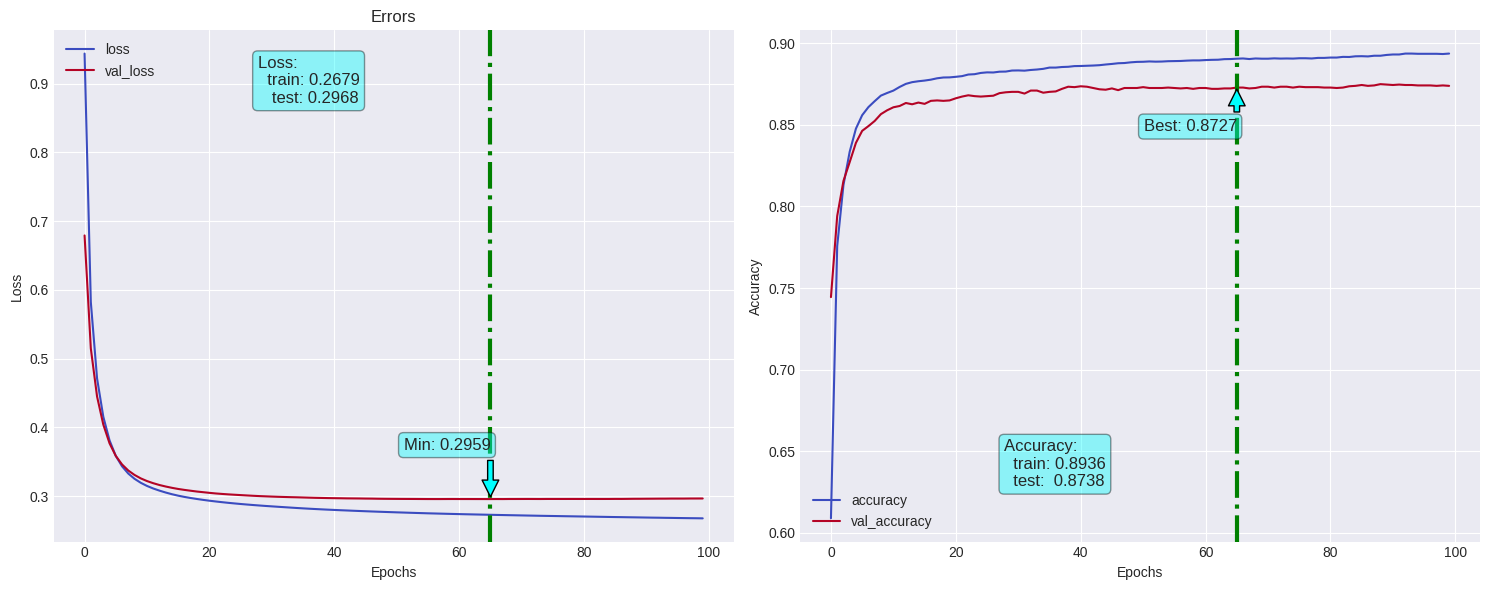

In [156]:
# fig, axes = plt.subplots(1, 2)
# hist_df.plot(y = ["loss", "val_loss"], ax = axes[0])
# hist_df.plot(y = ["accuracy", "val_accuracy"], ax = axes[1])

fn_plot_tf_hist(hist_df = hist_df)

Prediction Model

In [151]:
prediction_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Softmax()
])
prediction_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_9 (Sequential)            │ (None, 4)                   │             688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax_1 (Softmax)                  │ (None, 4)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 688 (2.69 KB)

 Trainable params: 688 (2.69 KB)

 Non-trainable params: 0 (0.00 B)

In [152]:
y_true, y_pred = [], []
for feat, lbls in train_ds:
    pred = prediction_model(feat).numpy()
    pred = pred.argmax(axis = 1)
    y_true.extend(lbls)
    y_pred.extend(pred)

len(y_true), len(y_pred)

(14336, 14336)

In [153]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1600
           1       0.92      0.94      0.93      4634
           2       0.86      0.86      0.86      5402
           3       0.85      0.81      0.83      2700

    accuracy                           0.89     14336
   macro avg       0.91      0.90      0.90     14336
weighted avg       0.89      0.89      0.89     14336



In [158]:
def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth
        y_pred : Predictions
        labels : labels in a dictonary
                  {0: 'Goal Keeper',
                  1: 'Defender',
                  2: 'Mid-Fielder',
                  3: 'Forward'}

    '''

    cm  = confusion_matrix(y_true, y_pred)

    if isinstance(labels, dict):
        display_labels = labels.values()
    else:
        display_labels = labels

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels)

    fig, ax = plt.subplots(figsize = (4,4))

    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)

    # Disable the grid
    ax.grid(False)

    plt.show()


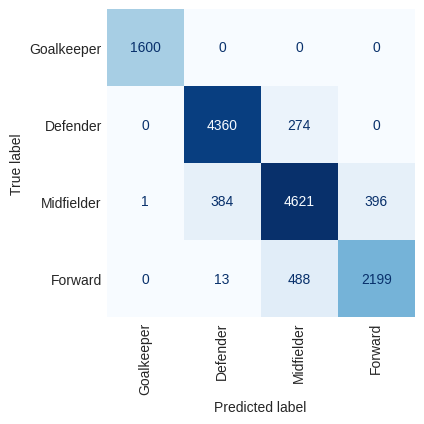

In [159]:
fn_plot_confusion_matrix(y_true, y_pred, labels = class_labels)

For Test Dataset

In [160]:
y_true, y_pred = [], []
for feat, lbls in test_ds:
    pred = prediction_model(feat).numpy()
    pred = pred.argmax(axis = 1)
    y_true.extend(lbls)
    y_pred.extend(pred)

len(y_true), len(y_pred)

(3811, 3811)

In [161]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       425
           1       0.91      0.93      0.92      1232
           2       0.83      0.84      0.83      1436
           3       0.82      0.77      0.79       718

    accuracy                           0.87      3811
   macro avg       0.89      0.89      0.89      3811
weighted avg       0.87      0.87      0.87      3811



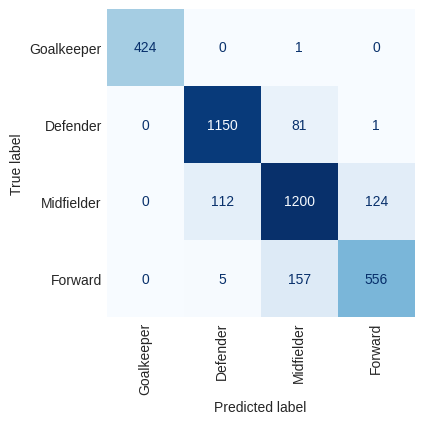

In [162]:
fn_plot_confusion_matrix(y_true, y_pred, labels = class_labels)